In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode, write_video
import torchvision.transforms as T
from random import randint
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output

import numpy as np
import pylab as pl
from importlib import reload  

from scripts import *
from CAModel import *

In [2]:
N_CHANNELS = 16        # Number of CA state channels
TARGET_PADDING = 16    # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
N_ITERS = 50           # Iterations before applying the loss
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

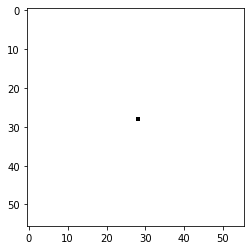

In [3]:
# Starting state
pool = SamplePool(POOL_SIZE, N_CHANNELS, IMAGE_SIZE)
imshow(pool[0][0])

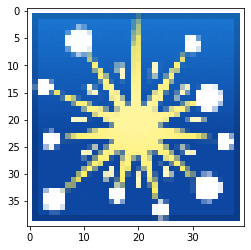

In [4]:
# Imports the target emoji
target = read_image("firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [5]:
# Custom loss function
class loss_fn:
    """Custom l2 or l1 loss function"""
    def __init__(self, target, order=2):
        self.order = order
        self.target = target
        
    def __call__(self, x):
        losses = torch.mean(torch.abs(x[:, :4, :, :] - self.target)**self.order, [1,2,3])
        idx_max_loss = torch.argmax(losses)
        loss = torch.mean(losses)
        return loss, idx_max_loss

target = target.cpu()
loss_fn(pad(target, TARGET_PADDING), 1)(pool.sample(16)[0])

(tensor(0.2883), tensor(0))

In [6]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target = target.to(device)

In [534]:
CA = CAModel().to(device)
CA.load("not_persistent.pt")

Successfully loaded model!


In [450]:
# Train the model
torch.backends.cudnn.benchmark = True

optimizer = torch.optim.Adam(CA.parameters(), lr=1e-4)
criterion = loss_fn(pad(target, TARGET_PADDING), order=2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
losses = []
torch.nn.utils.clip_grad_norm_(CA.parameters(), 1.)

tensor(2., device='cuda:0')

In [451]:
# Persistent CA training
for i in range(100):
    j = 0
    epoch_losses = []
    for j in range(POOL_SIZE//BATCH_SIZE):
        inputs, indexes = pool.sample(BATCH_SIZE)
        inputs = inputs.to(device)
        optimizer.zero_grad()
        
        for k in range(N_ITERS+randint(-10, 0)):
            inputs = CA(inputs)
            
        loss, idx_max_loss = criterion(inputs)
        loss.backward()
            
        optimizer.step()
        epoch_losses.append(loss.item())
        if j%2 != 0:
            idx_max_loss = None
        pool.update(inputs.detach().cpu(), indexes, idx_max_loss)
        j += 1
    print(np.mean(epoch_losses))
    clear_output(wait=True)
    losses.extend(epoch_losses)
    scheduler.step()

0.0037232292970657


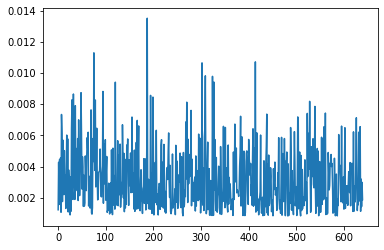

In [452]:
pl.plot(losses[::10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


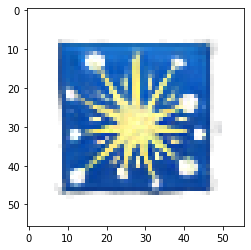

In [531]:
inputs, indexes = pool.sample(1)

imshow(inputs[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


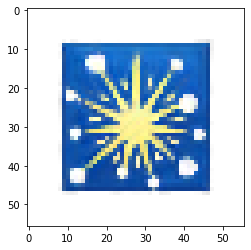

In [532]:
with torch.no_grad():
    inputs = inputs.cuda()
    for k in range(1000):
        inputs = CA(inputs)
imshow(inputs[0])

In [7]:
# loads a pretrained model
old_CA = CAModel().to(device)
old_CA.load("not_persistent.pt")

Successfully loaded model!


In [9]:
new_CA = CAModel().to(device)
new_CA.load("not_persistent.pt")

Successfully loaded model!


In [10]:
from double_CA import DoubleCA
model = DoubleCA(old_CA, new_CA)

In [119]:
# Train the model

torch.backends.cudnn.benchmark = True

for param in model.old_CA.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(model.new_CA.parameters(), weight_decay=1e-4)
criterion = loss_fn(pad(target, TARGET_PADDING), order=2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
losses = []
torch.nn.utils.clip_grad_norm_(model.new_CA.parameters(), 1.)

tensor(0.4159, device='cuda:0')

In [120]:
cell_mask = model.new_cells.cpu()
for i in range(10):
    j = 0
    for j in range(POOL_SIZE//BATCH_SIZE):
        inputs, indexes = pool.sample(BATCH_SIZE)
        inputs = inputs.to(device)
        if j%8 == 0:
            optimizer.zero_grad()
        
        for j in range(N_ITERS+randint(-10, 0)):
            inputs = model(inputs)
            
        loss, idx_max_loss = criterion(inputs)
        loss = loss / 8
        loss.backward()
        if j%8 == 0: 
            optimizer.step()
        losses.append(loss.item())
        pool.update(inputs.detach().cpu(), indexes, idx_max_loss)
        j += 1
    scheduler.step()

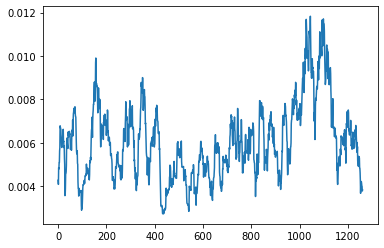

In [152]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

pl.plot(moving_average(losses,20))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


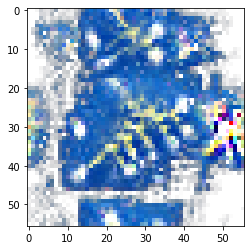

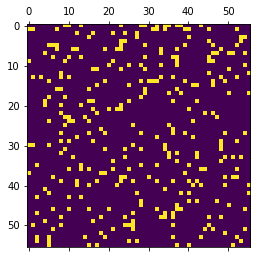

In [149]:
imshow(model.evolve(torch.unsqueeze(pool[0][0], 0).cuda(), 150)[0])
pl.matshow(model.new_cells.detach().cpu()[0,0])

In [29]:
model.new_cells.shape

torch.Size([1, 1, 56, 56])

In [ ]:
for i in range(10000):
    inputs, indexes = pool.sample(BATCH_SIZE)
    inputs = inputs.to(device, non_blocking=True)
    optimizer.zero_grad()
    
    model.update_cell_masks(inputs)
    for j in range(N_ITERS+randint(-10, 10)):
        inputs = model(inputs)
        
    loss, idx_max_loss = criterion(inputs)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())
    pool.update(inputs.detach().to("cpu", non_blocking=True), indexes, idx_max_loss)

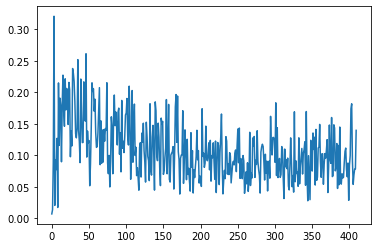

In [64]:
pl.plot(losses[::100])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


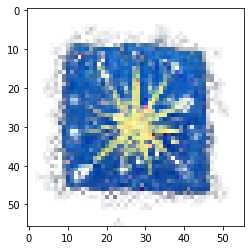

In [86]:
imshow(pool.sample(1)[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


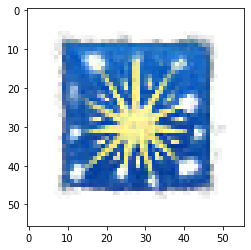

In [17]:
# Plots the learned CA
x, _ = pool.sample(1)
x = x.to(device)
x = model.evolve(x, N_ITERS)

imshow(x[0])

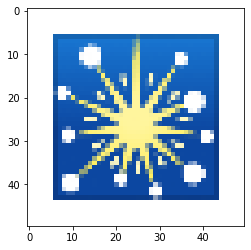

In [21]:
# Plots the true emoji
imshow(TraintoFloat(pad(target, 10, -1)))

In [ ]:
class MyDataset(Dataset):
    def __init__(self):
        self.data = torch.ones(5)
        
    def __getitem__(self, index):
        return self.data[index], index
    
    def update(self, index):
        self.data[index] = index.float()

    def __len__(self):
        return len(self.data)

dataset = MyDataset()
loader = DataLoader(
    dataset,
    num_workers=0,
    shuffle=False,
    pin_memory=True
)
for data, index in loader:
    print(data)
    dataset.update(index)
for data, index in loader:
    print(data)
print("\n")

dataset = MyDataset()
loader = DataLoader(
    dataset,
    num_workers=2,
    shuffle=False,
    pin_memory=True
)
for data, index in loader:
    print(data)
    dataset.update(index)
for data, index in loader:
    print(data)